Welcome to one of the collaborative Jupyter/Spark environments in ZHAW. You are not yet connected to Sparky by default. However, the necessary code template makes this a quick process. Keep in mind that you are sharing both the Jupyter environment and the Sparky cluster with others. Custom Python packages on the notebook/Spark driver side are installed with %pip install.

<div style="background-color:#add8e6; height:30px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366;">Abschnitt</strong>
</div>


In [232]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Wetter- und Luftqualitätsdaten") \
    .getOrCreate()

<div style="background-color:#add8e6; height:50px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366; font-size: 20px;">Inhaltsverzeichnis</strong>
</div>

## Übersicht des Inhalts

- **Luftqualität für AnfängerInnen**
<br> Hier erhalten wir einen kurzen Einblick in das Thema Luftqualität und die Bedeutung unserer Daten. <br>
- **Unsere Daten**
<br> In einem ersten Schritt ist es mir immer wichtig, ein paar kurze Checks zu machen. Dazu gehört u.a. das Prüfen, ob man im korrekten Directory ist, die DataFrames erstellen und anzeigen kann und so weiter. <br>
- **Fehlende Informationen**
<br> Da wir zwei Städte und zwei Tabellen haben, muss diese Information ebenfalls in den finalen Feature-Vektor einfliessen können. Das ist jedoch nur möglich, wenn wir eine zusätzliche Spalte erstellen (ansonsten ist die Info nur im File-Titel ersichtlich) mit dem numerischen Hinweis auf die Städte. Hier also ein Spalte namens "stadt" mit den Werten 0 und 1 für die zwei Städte.<br>
- **Feature-Vektor und Herausforderungen**
<br> Um den Feature-Vektor erstellen zu können, werden zuerst die beiden Tabellen zusammengeführt zu df_alle. Danach widme ich mich den Herausforderungen des Feature-Vektors. Dazu gehört u.a. das Problem, dass die **Zeiten nur als einzelne Spalten mit numerischen Werten** (sep Spalten für Jahr, Monat, Tag) und nicht als Timestamp in den Feature-Vektor einfliessen können.
Dazu gehört auch das **Casten** der noch verbliebenen Strings zu Doubles (zB für NO2, Ozon usw.) und das Prüfen, ob es auch **fehlende Werte** in der Tabelle gibt, da diese im Feature-Vektor zum Problem werden könnten.<br>
Zeilen mit fehlenden Werten einfach zu löschen, wäre jedoch schade um die Information. Daher werden zusätzliche Spalten erstellt mit Hinweisen dazu, dass besagte Werte gefehlt hatten. Es entstehen daher **Spaltenname_missing**-Spalten, die 0 und 1 enthalten als Information zum Fehlen des Werts.
Weiterhin jedoch müssen wir die Spalten irgendwie **befüllen**, zB wie hier mit einer 0.
<br>
- **Vektor-Erstellung**
<br> Sobald wir alle notwendigen Modifikationen gemacht haben, kann der Feature-Vektor erstellt werden. <br>
- **Standardisieren der Daten**
<br> Um mit ML-Algorithmen besser rechnen zu können und keine Verzerrungen zu verursachen durch zB sehr grosse Zahlen gewisser Einheiten, ist es wichtig, die Daten zu standardisieren. Das führt dazu, dass sie vergleichbarer sind und um 0 als ZEntrum gruppiert werden. <br>
- **Anomalien mit k-Means**
<br> Um Outlier zu entdecken, kann man zB wie hier k-Means verwenden. Beispielsweise für den Einsatz von k-Means war die Standardisierung der Werte sehr wichtig, da damit Abstände einheitlicher werden. Mit k-Means clustern wir und messen die Abstände zur Cluster-Mitte. So werden Auffälligkeiten wie Outlier deutlich. <br>
- **Pearson-Korrelation für Abhängigkeiten**
<br> Um mögliche Abhängigkeiten zwischen gewissen Features zu ermitteln, kann die Pearson-Korrelation verwendet werden.
Dabei bedeuten hohe Werte auf Abhängigkeiten hin, negative Werte hingegen können ein kompensierendes Verhältnis bedeuten.<br>
- **Regression für die Zukunftsvorhersage**
<br> Um herauszufinden, wie sich gewisse Features ggf. künftig verhalten, können wir Regression einsetzen und uns ein "Ziel-Feature" aussuchen. Dabei trennen wir den Datensatz auf in ein Prozentsatz an Test- und Trainingsdaten. Um zu sehen, wie gut unser Regressionsmodell abschneidet, können wir zB Root Mean Square Error als Evaluationswert verwenden. Niedrige Werte können auf ein präzises Modell verweisen... <br>
- **Random-Forest für die Missingness**
<br> Da wir Informationen zu den fehlenden Werten abgespeichert haben, können wir auch diese für Vorhersagen nutzen. Bei Random-Forests können wir auch die Gewichtung der Features herausfinden, was ein grosser Pluspunkt für das Verständnis der Funktionsweise ist. <br>
- **Windows als Optimierungsmöglichkeit**
<br> Eine Möglichkeit, verständlichere Resultate zu produzieren, ist das Verwenden von Zeitfenstern. Diese glätten über kurze Zeiträume und zeigen dennoch langfristig Trends. => Natürlich abhängig vom gewählten Window <br>
- **Fazit**
<br> Man könnte noch deutlich mehr machen...aber das mal als Vorgeschmack darauf, was Spark Mllib alles bietet. <br>

<div style="background-color:#add8e6; height:50px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366; font-size: 20px;">Vorbereitung des Machine Learnings</strong>
</div>


<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> xxxx.
</div>


<div style="padding: 10px; background-color: #ffe6e6; border-left: 6px solid #ff4c4c;">
  <b>Warnung:</b> xxx!
</div>


<div style="padding: 10px; background-color: #e7f3fe; border-left: 6px solid #2196F3;">
  <b>Tipp:</b> xxx
</div>


<div style="padding: 20px; background-color: lightgreen; border-left: 6px solid green; border-right: 6px solid green;">
    <h1>Luftqualität für AnfängerInnen</h1>


Als Nicht-Meteorolog:innen und komplette Anfänger:innen in Sachen Luftqualität, war es auch für uns wichtig, uns einen kurzen ÜBerblick über das Thema zu verschaffen, um in der Folge mit den gegebenen Daten arbeiten zu können.

### Erläuterung Luftqualitätsdaten (Bezeichnungen in Tabellenheader)

| Spalte      | Bedeutung                                                                                 |
|-------------|--------------------------------------------------------------------------------------------|
| **Startzeit** | Beginn der Messperiode (Datum und Uhrzeit)                                               |
| **Endzeit**   | Ende der Messperiode (Datum und Uhrzeit)                                                 |
| **PM10**      | Partikel mit einem Durchmesser ≤ 10 µm (z. B. Staub, Pollen, Russ)                        |
| **PM2.5**     | Feinpartikel ≤ 2.5 µm – können tief in die Lunge eindringen und gesundheitsschädlich sein |
| **Ozon**      | Ozon (O₃) – entsteht bei Sonneneinstrahlung aus NOₓ und VOCs, bodennah schädlich         |
| **CO**        | Kohlenmonoxid – entsteht bei unvollständiger Verbrennung, giftig bei hohen Konzentrationen. Farb- und geruchloses Gas, meist durch Verkehr und Verbrennung fossiler Stoffe |
| **NO2**       | Stickstoffdioxid – Reizgas, das bei Verbrennung (z. B. Strassenverkehr) entsteht                  |
| **NO**        | Stickstoffmonoxid – Vorläufer von NO₂, entsteht direkt bei Verbrennungsprozessen         |



<br>
<br>
<br>

**Und wie hängen diese Stoffe zusammen?**

**NO** und **NO2** stehen in direktem Zusammenhang, NO wird z.B. durch Autos verursacht und oxidiert in heissen Städten in der Luft zu NO2.
<br>
**Ozon** (O3) bildet sich aus NOx (Stickstoffoxiden) und flüchtigen organischen Verbindungen (VOCs) unter Sonneneinstrahlung. 
<br> => d.h. dass an sonnigen Tagen mit viel Verkehr Ozon- als auch NO2-Werte steigen.
<br>
**PM10** und **PM2.5** können z.B. aus direkten Emissionen wie Reifenabrieb, Verbrennung usw. als auch sekundär in der Atmosphäre (Reaktionen) entstehen.
<br>
**CO** entsteht bei unvollständiger VErbrennnung. Konzentration korreliert oft mit PM-Werten und anderen Abgasen.
<br>
<br>
Diese Stoffe können HErz-Kreislauf-, Lungenerkrankungen, generell Atemnot, Husten, Müdigkeit usw. verursachen und sind daher für unsere Gesundheit relevante Umweltfaktoren.
<br>
</div>

# Big Data Leistungsnachweis 🤖

<br>
Wie beeinflusst das Wetter die Luftqualität?“ – Vergleich zwischen Zürich und St. Gallen mit Spark MLlib


<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> Dieser Teil ist nicht unbedingt notwendig, aber für mich immer sinnvoll.
</div>

In [233]:
#Kurzes Prüfen, ob man im korrekten Directory unterwegs ist und die Files sichtbar sind
import os
os.listdir(".")  # Liste der Files im Working Directory


['.DS_Store',
 '.git',
 '.idea',
 '.ipynb_checkpoints',
 '.jupyter',
 '01_LoadData.ipynb',
 '02_ML.ipynb',
 '03_Visualisation.ipynb',
 'data',
 'README.md']

<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> Im Folgenden sind mir gelegentlich beim Erarbeiten Fehler unterlaufen, die dann nachträglich korrigiert wurden. Schönheitsfehler seien mir daher hoffentlich verziehen. Ich habe mein Bestes getan, auch an den jweiligen Stellen darauf aufmerksam zu machen, was mein Fehler bzw. Fix war.
</div>

## Stadt hinzufügen (vor Feature-Vektor-ERstellung)
Um Problemen vorzubeugen, ist noch die Stadt zu jeder Zeile hinzuzufügen. Diese würde ansonten beim Zusammenführen der Daten verlorengehen (da aktuell nur im NAmen des Files enthalten und nicht im eigentlichen File).
<br>
Ein erster Fehler war es, dass ich die Stadt als String in der Spalte hinzugefügt habe. Das führt natürlich dazu, dass der ML-Algorithmus später das nicht im Feature-Vektor interpretieren kann. Ein Fehler, der dazu führt, dass die Städte nicht als separate Phänomene analysiert werden können.
<br>
Nun werden die Städte in einer sep. Spalte ("stadt") mit 0 und 1 gekennzeichnet. 
<br>
**0 = Zürich** <br>
**1 = St.Gallen**


In [234]:
df_alle = spark.read.option("header", True) \
                .option("delimiter", ",") \
                .csv("data/cleaned/cleaned_Data.csv")

In [235]:
from pyspark.sql.functions import when
df_alle = df_alle.withColumn(
    "stadt",
    when(df_alle["location"] == "Zürich", 0)
    .when(df_alle["location"] == "St. Gallen", 1)
    .otherwise(3)
)


Der <b>Dezimalpunkt</b> im HEader könnte ein PRoblem darstellen (PM2.5). DAher ändern wir diesen zu einem _


In [236]:
df_alle = df_alle.withColumnRenamed("PM2.5", "PM2_5")

## Feature-Vektor erstellen
ML-Algorithmen erwarten meistens die Daten zusammen in einem Feature-Vektor.

<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> Der gewählte Titel ist darauf zurückzuführen, dass ich ein wenig zu optimistisch war, was das schnelle Erstellen des FEature-Vektors anbelangt ;)...
</div>

In [237]:
#Wir wollen auch kurz prüfen, ob das geklappt hat und Einträge für beide Städte vorhanden sind
df_alle.select("stadt").distinct().show()
#korrekter Output wäre stadt zh sg in einer kleinen TAbelle

+-----+
|stadt|
+-----+
|    1|
|    0|
+-----+



Zum Erstellen eines Feature-Vektors müssen wir die Feature-Spalten auswählen. Dabei handelt es sich um die numerischen Werte (diese können wir nachher auch standardisieren). Andere Typen müssen weggelassen werden, daher siehe oben zum Thema Stadt.

In [238]:
df_alle.printSchema()
#BEim Printen des Schemas zeigt sich, dass alle COlumns noch als String ausser stadt interpretiert werden, darum funktioniert dabei assembler.transform nicht
#Wir müssen also zuerst die Strings umwandeln

root
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- PM2_5: string (nullable = true)
 |-- Ozon: string (nullable = true)
 |-- CO: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- NO: string (nullable = true)
 |-- Air temperature 2 m above ground daily mean: string (nullable = true)
 |-- Air temperature 2 m above ground daily maximum: string (nullable = true)
 |-- Air temperature 2 m above ground daily minimum: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily mean: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily maximum: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily minimum: string (nullable = true)
 |-- Relative air humidity 2 m above ground daily mean: string (nullable = true)
 |-- Vapour pressure 2 m above ground daily mean: string (nullable = true)
 |-- Atmospheric pressure at barometric altitude (QFE) daily mean: string (nulla

In [239]:
df_alle.columns


['date',
 'location',
 'PM10',
 'PM2_5',
 'Ozon',
 'CO',
 'NO2',
 'NO',
 'Air temperature 2 m above ground daily mean',
 'Air temperature 2 m above ground daily maximum',
 'Air temperature 2 m above ground daily minimum',
 'Air temperature at 5 cm above grass daily mean',
 'Air temperature at 5 cm above grass daily maximum',
 'Air temperature at 5 cm above grass daily minimum',
 'Relative air humidity 2 m above ground daily mean',
 'Vapour pressure 2 m above ground daily mean',
 'Atmospheric pressure at barometric altitude (QFE) daily mean',
 'Pressure reduced to sea level (QFF) daily mean',
 'Geopotential height of the 850 hPA level daily mean',
 'Geopotential height of the 700 hPA level daily mean',
 'Pressure reduced to sea level according to standard atmosphere (QNH) daily mean',
 'Wind speed scalar daily mean in m/s',
 'Gust peak (one second) daily maximum in m/s',
 'Wind speed scalar daily mean in km/h',
 'Gust peak (one second) daily maximum in km/h',
 'Gust peak (three seconds)

In [240]:
umweltfaktoren = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO"]
for c in umweltfaktoren:
    if c not in df_alle.columns:
        print(f"Spalte nicht gefunden, wg. NAmensproblem: '{c}'")
    else: 
        print(f"Spalte '{c}'vorhanden")


Spalte 'PM10'vorhanden
Spalte 'PM2_5'vorhanden
Spalte 'Ozon'vorhanden
Spalte 'CO'vorhanden
Spalte 'NO2'vorhanden
Spalte 'NO'vorhanden


<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> Man bemerke...ich prüfe gerne, ob noch alles da ist, wo ich es zurückgelassen habe....
</div>

In [241]:
from pyspark.sql.functions import col, regexp_replace

umweltfaktoren = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO"]
#umwandeln der Strings für die umweltfaktoren-werte in double
for c in umweltfaktoren: #hier noch eine Vorsichtsmassnahme, indem allfällige Kommas zu Punkten für Dezimaldarstellung ugmwandelt werden
    df_alle = df_alle.withColumn(c, regexp_replace(col(c), ",", ".").cast("double"))


In [242]:
#hier ein erster simpler Versuch, das zu einem fEature-Vektor zu machen...
#theoretisch wegzulassen, da noch weitere Anpassungen später vorgenommen werden
#zum jetzigen Zeitpunkt fehlt noch einiges, zB korrekter Umgang mit NULL usw.

from pyspark.ml.feature import VectorAssembler

umweltfaktoren = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO"]

assembler = VectorAssembler(inputCols=umweltfaktoren, outputCol="rawFeatures")
df_vector = assembler.transform(df_alle).dropna(subset=["rawFeatures"])


In [243]:
df_vector.select(umweltfaktoren).printSchema()
#Sind wirklich alle nun Doubles und keine Strings? Wichtig für weitere ARbeit

root
 |-- PM10: double (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- Ozon: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NO: double (nullable = true)



In [244]:
df_alle.select(umweltfaktoren).summary().show() #Kurzer Blick auf die SPalten, ggf fällt hier noch etwas auf
#hier fällt zB auf, dass für gewisse Spalten nur sehr wenige Einträge vorhanden sind...
#auch fällt auf, dass der Mean für Ozon bei 37.9 und für NO2 bei 11.7, nur als BEispiele, liegt und somit doch deutlich auseinander...siehe Standardisierung

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|              PM10|             PM2_5|             Ozon|                CO|               NO2|               NO|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|              3613|              3613|             1809|              1781|              3593|             1811|
|   mean|11.003501245502333|10.979950179905902|37.87614704256498|38.217428411005066|21.134703590314498| 11.9187134180011|
| stddev|6.6633460239670494| 6.996750174881126|9.097815904290787| 9.601133805416268|13.644620413668811|10.02851625007639|
|    min|              1.46|              1.39|            11.55|             14.32|              0.95|              0.6|
|    25%|              6.43|              6.06|            32.32|             32.02|             11.04|             6.12|
|    50%|              9

<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> An der Darstellung lässt sich noch arbeiten.
</div>

In [245]:
from pyspark.sql.functions import col, isnan

df_alle.select([
    col(c).isNull().alias(f"{c}_null") for c in umweltfaktoren
] + [
    isnan(c).alias(f"{c}_nan") for c in umweltfaktoren
]).show()

#hier sehen wir, wo überall fehlende Werte zu finden sind...es scheinen viele zu sein, da bereits in den oberen Zeilen viele erscheinen

+---------+----------+---------+-------+--------+-------+--------+---------+--------+------+-------+------+
|PM10_null|PM2_5_null|Ozon_null|CO_null|NO2_null|NO_null|PM10_nan|PM2_5_nan|Ozon_nan|CO_nan|NO2_nan|NO_nan|
+---------+----------+---------+-------+--------+-------+--------+---------+--------+------+-------+------+
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     true|  false|   false|   true|   false|    false|   false| false|  false| false|
|    false|     false|     t

### Ungültige Werte
Bevor wir weiterarbeiten müssen wir wissen, ob wir Rows mit falschen Werten droppen oder ob wir die Werte besser einfüllen (Ersteres ist nur dann geeignet, wenn nicht viele betroffen sind).

In [246]:
df_alle.filter("PM10 is null OR `PM2_5` is null OR Ozon is null OR CO is null OR NO2 is null OR NO is null").count()

#hier erhalten wir die Zeilen-Anzahl der fehlenden Werte...mit 3954 sind das sehr viele und können nicht einfach gedroppt werden

3620

In [247]:
total = df_alle.count()

fehlend = df_alle.filter(
    "PM10 is null OR `PM2_5` is null OR Ozon is null OR CO is null OR NO2 is null OR NO is null"
).count()

print(f"Fehlend {fehlend} von total {total} Rows ({(fehlend/total)*100:.2f}%)")

#hier sehen wir, dass alle Zeilen betroffen sind

Fehlend 3620 von total 3620 Rows (100.00%)


In [248]:
from pyspark.sql.functions import count, when, col, isnan

df_alle.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()
#Hier stellt sich leider heraus, dass wir etliche fehlende Werte zu haben scheinen
#U.a. haben wir z.B. bei Ozon alleine 1980 und bei CO 2008 oder bei NO 1978 fehlende WErte

+------------+-------------+------------+----------+-----------+----------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|
+------------+-------------+------------+----------+-----------+----------+
|           7|            7|        1811|      1839|         27|      1809|
+------------+-------------+------------+----------+-----------+----------+



Wir wollen nicht alle Rows wegwerfen, die fehlende WErte haben...aber es wäre auch sinnlos, diese mit Nullen zu befüllen, da es sich um so viele Rows handelt.
<br>
Wir wollen die Information speichern, dass hier Werte fehlen. Das können wir, indem wir eine neue Spalte erstellen, in der wir diese Information speichern (binär). 
<br>
Wir erstellen also eine Spalte für Ozon_missing, CO_missing und NO_missing und befüllen dies jeweils mit 0 bzw. 1 (Letzteres für fehlende Werte). D.h. 0 = Wert vorhanden, 1 = Wert fehlt.
<br>
Die anderen drei Spalten mit 13 oder 31 fehlenden Werten droppen wir, da es sich um eine kleine Anzahl handelt.

In [249]:
#Droppen der Reihen mit fehlenden Werten für PM10, PM2_5 und NO2, da es sich hierbei nur um eine Handvoll fehlende WErte handelt
cols_to_drop_on = ["PM10", "PM2_5", "NO2"]

df_cleaned = df_alle.dropna(subset=cols_to_drop_on)


In [250]:
#Wir prüfen, ob das geklappt hat und jetzt jeweils 0 bei den Spalten steht
from pyspark.sql.functions import count, when, col, isnan

df_cleaned.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()

+------------+-------------+------------+----------+-----------+----------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|
+------------+-------------+------------+----------+-----------+----------+
|           0|            0|        1779|      1810|          0|      1779|
+------------+-------------+------------+----------+-----------+----------+



In [251]:
#im nächsten Schritt werden wir sep. Spalten zum Erhalten der Information zu den fehlenden WErten erstellen
#das ändert zwar nichts daran, dass wir die Felder irgendwie befüllen müssen, erhält aber die Information, dass der Wert gefhelt hatte
from pyspark.sql.functions import when, col

cols_to_flag = ["Ozon", "CO", "NO"]

for c in cols_to_flag:
    df_cleaned = df_cleaned.withColumn(f"{c}_missing", when(col(c).isNull(), 1).otherwise(0))


In [252]:
df_cleaned.select("Ozon", "Ozon_missing", "CO", "CO_missing", "NO", "NO_missing").show(10)
#Wir prüfen kurz, ob das geklappt hat und wir nun jeweils dazu passende "_missing"-Spalten haben mit 1 und 0

+----+------------+-----+----------+----+----------+
|Ozon|Ozon_missing|   CO|CO_missing|  NO|NO_missing|
+----+------------+-----+----------+----+----------+
|null|           1|21.11|         0|null|         1|
|null|           1| 26.5|         0|null|         1|
|null|           1|36.66|         0|null|         1|
|null|           1|35.72|         0|null|         1|
|null|           1|28.78|         0|null|         1|
|null|           1|31.55|         0|null|         1|
|null|           1|30.09|         0|null|         1|
|null|           1| 35.4|         0|null|         1|
|null|           1|40.12|         0|null|         1|
|null|           1|35.56|         0|null|         1|
+----+------------+-----+----------+----+----------+
only showing top 10 rows



Nun dürfen wir nicht vergessen, dass wir dennoch die empty Felder mit etwas befüllen müssen.
Wir wählen mal 0 als Wert, da es uns fast schon zu sehr an Einträgen fehlt, um einen MEdian oder ÄHnliches zu berechnen.

In [253]:
df_cleaned = df_cleaned.fillna({
    "CO": 0,
    "Ozon": 0,
    "NO": 0
})
#überall wo na ist, wird eine 0 eingefügt

In [254]:
#neu sollten wir hier also überall 0 als Wert für die Anzahl an NA-Werten erhalten
from pyspark.sql.functions import count, when, col, isnan

df_cleaned.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()

+------------+-------------+------------+----------+-----------+----------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|
+------------+-------------+------------+----------+-----------+----------+
|           0|            0|           0|         0|          0|         0|
+------------+-------------+------------+----------+-----------+----------+



### Zeiten als Features extrahieren

Um mit Datum und Zeit wetierarbeiten zu können im Feature-Vektor, müssen wir diese als numerische sep. Werte speichern und nicht als ZEitstempel (dieser nützt uns nichts).
Daher hier mit einer Spalte pro Eintrag, was zu 10 neuen Spalten fürht (Jahr, Moant, Tag, Wochentag, Stunde) und das für Start- und Endzeit.
Die Stunde hätte man sich sparen können, hier aber aus Vollständigkeitsgründen. Der Wochentag ist ein Plus für allfällige weitere Analysen.

In [255]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

df_cleaned = df_cleaned.withColumn("year", year("date")) \
                 .withColumn("month", month("date")) \
                 .withColumn("day", dayofmonth("date")) \
                 .withColumn("weekday", dayofweek("date")) \
                 .withColumn("hour", hour("date"))



#genau genommen könnte man die Spalten zur Stunde, hour_e und hour_s, auch einfach weglassen, da eh immer 00:00...hier aber der Vollständigkeit halber
#Weekday mitaufzunehmen ist ein zusätzliches Feature, welches sich vielleicht als nützlich erweisen kann

<div style="padding: 10px; background-color: #fff8c4; border-left: 6px solid #f7d205;">
  <b>Anmerkung:</b> Falls BEdarf da wäre, liessen sich hier die Stunden weglassen. Solange das aber kein Heu frisst, lasse ich es für das Verständnis.
</div>

In [256]:
#Spalten-Preview nach Zeiten-Extraktion
df_cleaned.select("date", "year", "month", "day", "weekday", "hour").show(10, truncate=False)


+----------+----+-----+---+-------+----+
|date      |year|month|day|weekday|hour|
+----------+----+-----+---+-------+----+
|2020-01-02|2020|1    |2  |5      |0   |
|2020-01-03|2020|1    |3  |6      |0   |
|2020-01-04|2020|1    |4  |7      |0   |
|2020-01-05|2020|1    |5  |1      |0   |
|2020-01-06|2020|1    |6  |2      |0   |
|2020-01-07|2020|1    |7  |3      |0   |
|2020-01-08|2020|1    |8  |4      |0   |
|2020-01-09|2020|1    |9  |5      |0   |
|2020-01-10|2020|1    |10 |6      |0   |
|2020-01-11|2020|1    |11 |7      |0   |
+----------+----+-----+---+-------+----+
only showing top 10 rows



In [257]:
df_cleaned.show()

+----------+--------+-----+-----+----+-----+-----+---+-------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------+------------------------------------------------------------+----------------------------------------------+---------------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------------------+-----------------------------------+-------------------------------------------+------------------------------------+--------------------------------------------+----------------------------------------------+-----------------------------------------------+------------------

### Vektor erstellen

Den eigentlichen Vektor - nach einem nun sehr langen Exkurs - erstellen wir basierend auf den dafür geeigneten Spalten. D.h. es kommen nur Spalten mit numerischen Werten infrage.
<br>
Das heisst, wir haben folgende Spalten, die geeignet sind: <br>
"PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing", "year_e", "month_e", "day_e", "weekday_e", "hour_e", "year_s", "month_s", "day_s", "weekday_s", "hour_s", "stadt"

In [258]:
#wir definieren, welche Spalten wir gerne als Features hätten 
#numerische Spalten als Features, keine Strings oder Timestamps
feature_cols = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing",  "year", "month", "day", "weekday", "hour", "stadt"]


In [259]:
#Feature-Vektor erstellen mit VectorAssembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df_cleaned)  # NAme des aktuellen DataFrames ist df_cleaned

In [260]:
df_vector.select("Ozon_missing", "CO_missing", "NO_missing").printSchema()


root
 |-- Ozon_missing: integer (nullable = false)
 |-- CO_missing: integer (nullable = false)
 |-- NO_missing: integer (nullable = false)



In [261]:
#Vorschau, ob das geklappt hat mit dem Feature-Vektor
df_vector.select("features").show(5, truncate=False)


+------------------------------------------------------------------------+
|features                                                                |
+------------------------------------------------------------------------+
|[16.21,18.43,0.0,21.11,18.87,0.0,1.0,0.0,1.0,2020.0,1.0,2.0,5.0,0.0,0.0]|
|[16.91,20.09,0.0,26.5,26.71,0.0,1.0,0.0,1.0,2020.0,1.0,3.0,6.0,0.0,0.0] |
|[6.8,8.8,0.0,36.66,13.54,0.0,1.0,0.0,1.0,2020.0,1.0,4.0,7.0,0.0,0.0]    |
|[8.88,11.52,0.0,35.72,21.15,0.0,1.0,0.0,1.0,2020.0,1.0,5.0,1.0,0.0,0.0] |
|[19.23,23.17,0.0,28.78,50.18,0.0,1.0,0.0,1.0,2020.0,1.0,6.0,2.0,0.0,0.0]|
+------------------------------------------------------------------------+
only showing top 5 rows



## Standardisierung der numerischen Daten
Standardisieren der numerischen Daten in einen Range von -1 bis 1.
<br>
Je nach verwendeter MEthode ist das sinnvoll und nützlich (ABhängigkeit von Distanzenberechnung). Zu diesen MEthoden gehört z.B. k-Means, logistische Regression, SVMs. Weniger wichtig ist es bei Tree-Methoden.
<br> 
Der kleinste Wert wird auf -1 gemappt und der grösste auf 1. Der Rest wird entsprechend dazwischen gemappt.
<br>


In [262]:
#Zum Standardisieren arbeiten wir mit StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,  # 0 als Mitte
    withStd=True    # Einheitsvarianz skalieren
)

scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


In [263]:
df_scaled.select("scaledFeatures").show(5, truncate=False)
#kurze Preview, neu sollten alle Werte ungefähr zwischen -1 und 1 angezeigt werden

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.7821901476482623,1.0637332452112878,-0.9537392522076718,0.10662930640777186,-0.16412363443663278,-0.6467992883685725,1.0076983318480472,-1.00

<div style="background-color:#add8e6; height:60px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366; font-size: 30px">Machine Learning mit Spark MLlib</strong>
</div>


## ANomalien entdecken
Mittels k-Means probieren wir, ob wir irgendwelche Anomalien entdecken können.

In [264]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=4, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)

#wir clustern mit k-Means

In [265]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors

#hier messen wir die Distanz der Punkte zur Cluster-Mitte

centers = model.clusterCenters()

def distance_from_center(vec, cluster_id):
    return float(np.linalg.norm(vec.toArray() - centers[cluster_id]))

distance_udf = udf(distance_from_center)

df_clustered = df_clustered.withColumn("distance_to_center", distance_udf("scaledFeatures", "cluster"))


In [266]:
#wir sortieren nach Distanz zur Mitte, hier also zB die obersten 10 auffälligsten Zeilen
df_sorted = df_clustered.orderBy(col("distance_to_center").desc())
df_sorted.select("distance_to_center", "cluster", "features").show(10, truncate=False)


+------------------+-------+---------------------------------------------------------------------------+
|distance_to_center|cluster|features                                                                   |
+------------------+-------+---------------------------------------------------------------------------+
|9.75569785932399  |1      |[26.55,73.35,0.0,31.93,66.79,0.0,1.0,0.0,1.0,2021.0,2.0,24.0,4.0,0.0,0.0]  |
|8.864911148316319 |3      |[76.09,28.0,37.95,0.0,53.3,38.05,0.0,1.0,0.0,2021.0,2.0,25.0,5.0,0.0,1.0]  |
|8.764817141797888 |3      |[75.77,26.36,39.45,0.0,58.43,37.04,0.0,1.0,0.0,2021.0,2.0,24.0,4.0,0.0,1.0]|
|8.344757933024615 |3      |[31.88,39.21,0.0,28.62,99.52,0.0,1.0,0.0,1.0,2020.0,1.0,25.0,7.0,0.0,0.0]  |
|8.152264209061938 |1      |[24.53,33.93,0.0,25.41,112.37,0.0,1.0,0.0,1.0,2021.0,11.0,11.0,5.0,0.0,0.0]|
|7.822786392102805 |1      |[44.65,50.69,0.0,32.87,23.84,0.0,1.0,0.0,1.0,2023.0,3.0,4.0,7.0,0.0,0.0]   |
|7.821047755728676 |3      |[67.66,19.09,51.02,0.0,24.0

## Korrelationen in Entwicklung
Mit der Pearson-Korrelation können wir schauen, ob es irgendwelche ABhängikeiten zwischen gewissen Features gibt. Entwickeln sich zB Feature 1 und 2 gemeinsam...? mit einer Pearson-Korrelations-Matrix lässt sich messen, wie zwei Variablen im VErhältnis sich bewegen.
<br>
Hohe absolute Werte (nahe bei 1) gehören zusammen. Negative Korrelationen hingegen können auf kompensierendes Verhalten hindeuten.

In [267]:
from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(df_scaled, "scaledFeatures") #berechnen der Pearson-Matrix


C:\Users\lhenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [268]:
#Hier die Variante zusätzlich mit Visualisierung
matrix = Correlation.corr(df_scaled, "scaledFeatures").head()[0]

# zu numpy array
corr_array = matrix.toArray()

feature_names = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing", "year", "month", "day", "weekday", "hour", "stadt"]

corr_df = pd.DataFrame(corr_array, index=feature_names, columns=feature_names)

# visualisieren
print(corr_df.round(2))


              PM10  PM2_5  Ozon    CO   NO2    NO  Ozon_missing  CO_missing  \
PM10          1.00   0.60  0.26 -0.24  0.50  0.33         -0.24        0.24   
PM2_5         0.60   1.00 -0.43  0.43  0.20 -0.19          0.45       -0.45   
Ozon          0.26  -0.43  1.00 -0.89  0.37  0.56         -0.95        0.94   
CO           -0.24   0.43 -0.89  1.00 -0.46 -0.60          0.94       -0.94   
NO2           0.50   0.20  0.37 -0.46  1.00  0.59         -0.38        0.38   
NO            0.33  -0.19  0.56 -0.60  0.59  1.00         -0.64        0.64   
Ozon_missing -0.24   0.45 -0.95  0.94 -0.38 -0.64          1.00       -1.00   
CO_missing    0.24  -0.45  0.94 -0.94  0.38  0.64         -1.00        1.00   
NO_missing   -0.24   0.45 -0.95  0.94 -0.38 -0.64          1.00       -1.00   
year         -0.10  -0.12 -0.02 -0.01 -0.19 -0.11         -0.00        0.00   
month        -0.12  -0.09 -0.08 -0.07  0.00  0.04         -0.01        0.01   
day           0.01   0.01  0.01  0.01  0.01  0.01   

### Interpretationsmöglichkeiten der Pearson-Matrix

Bei Werten, die nahe bei 1.0 sind, ist von einer starken Korrelation auszugehen. In gewissen fällen ist das auch erwartbar. So haben die PM10 und PM2_5 Spalten eher hohe Werte, die sie miteinander erreichen, da sie durch ähnliche Umweltbedingungen entstehen bzw. miteinander in enger Beziehung stehen.

Cluster als interessante Visualisierung...

In [269]:
df_clustered.groupBy("cluster").count().show()
#wir können uns die gebildeten Cluster ansehen

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 1777|
|      3|  344|
|      2|  762|
|      0|  703|
+-------+-----+



## Wir sehen uns die Cluster mal kurz an...

In [270]:
cluster_counts = df_clustered.groupBy("cluster").count().toPandas()
#kurz in Panda-Dataframe umwandeln für Visualisierung nachher

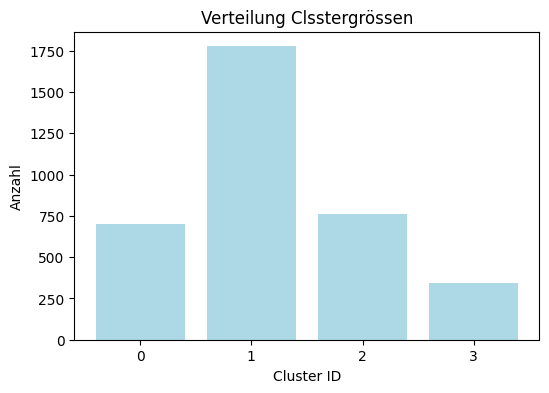

In [271]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(cluster_counts["cluster"], cluster_counts["count"], color="lightblue")
plt.xlabel("Cluster ID")
plt.ylabel("Anzahl")
plt.title("Verteilung Clsstergrössen")
plt.xticks(cluster_counts["cluster"])
plt.show()


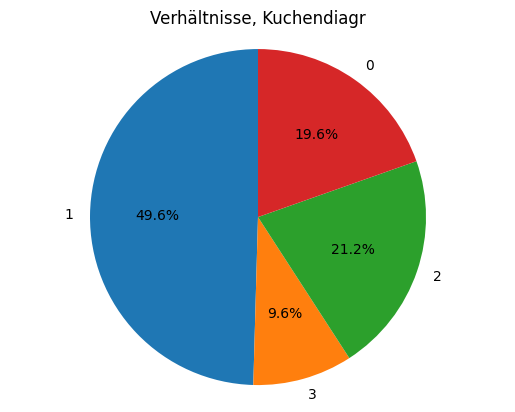

In [272]:
plt.pie(cluster_counts["count"], labels=cluster_counts["cluster"], autopct='%1.1f%%', startangle=90)
plt.title("Verhältnisse, Kuchendiagr")
plt.axis("equal")
plt.show()


Um jedoch zu verstehen, was wir hier eigentlich sehen und was die Cluster bedeuten, müssen wir uns näher damit auseinandersetzen.

In [273]:
df_clustered.groupBy("cluster").avg("PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing", "year", "month", "day", "weekday", "hour").show()
#zB können wir die durcschn Werte in einem Cluster ermitteln, um zu sehen, ob uns da etwas auffällt

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+---------+
|cluster|         avg(PM10)|        avg(PM2_5)|         avg(Ozon)|            avg(CO)|          avg(NO2)|           avg(NO)|   avg(Ozon_missing)|     avg(CO_missing)|     avg(NO_missing)|         avg(year)|       avg(month)|          avg(day)|      avg(weekday)|avg(hour)|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+---------+
|      1| 9.360016882386049|14.128030388294862|               0.0|    38.208069780529|15.875998874507557|               0.0|                 1.0|0.001688238604389...|               

## Prognosen und künftige Entwicklungen
Wenn wir einen Blick in die Zukunft werfen und herausfinden wollen, welchen Wert es für eine bestimmte SPalte morgen geben wird, können wir das wie folgt:
<br>
Wir müssen uns für einen Ziel-Wert entscheiden. Den Ziel-Wert wollen wir schlussendlich dann vorhersagen können.
<br>
Da wir bereits unseren Feature-Vector haben, können wir direkt zum Schritt mit der Aufteilung von Test-Trainings-Daten gehen.

In [274]:
#Aufteilung der Daten in Trainings- und Test-Daten, in Prozent % 
train, test = df_clustered.randomSplit([0.8, 0.2], seed=42)


In [275]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="scaledFeatures", labelCol="PM10")
model = lr.fit(train)
#wir wählen unser gesuchtes Feld labelCol und wenden linregression auf die Features an

In [276]:
predictions = model.transform(test)
predictions.select("PM10", "prediction").show(10)
#hier machen wir mal ein paar Vorhersagen und sehen, wie korrekt diese waren
#links in der TAbelle die tatscählichen Werte und rechts die vorhergesagten

+-----+------------------+
| PM10|        prediction|
+-----+------------------+
|10.88|10.880227506804665|
| 9.94|  9.94024823788832|
|14.15|14.150245712984368|
|16.96| 16.95995756298822|
| 9.08| 9.080035110457807|
|17.77|17.769923570590468|
|10.12|10.119978331957347|
| 7.79| 7.790068778553648|
|31.88|31.879976397726875|
|22.91| 22.91031323667192|
+-----+------------------+
only showing top 10 rows



In [277]:
#Unser Model können wir auch evaluieren
#Mit dem sog. root mean squared error, rmse, finden wir heraus, wie korrekt die Vorhersagen sind
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="PM10", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error =", rmse)
#beim rmse gilt: je kleiner desto besser

Root Mean Squared Error = 0.0001450127708130888


Mehr zu Evaluationsmethoden und dem RMSE finden sich hier: https://spark.apache.org/docs/4.0.0/mllib-evaluation-metrics.html
<br>
Mit dem RMSE können generell Regressionsmodelle evaluiert werden.Damit wird die Unterschiedsgrösse von vorhergesagten und tatsächlichen Werten berechnet (grosse Unterschiede werden bestraft bzw. der RMSE reagiert stark auf Outliers).
<br>
Der RMSE ist immer positiv und ein Wert von 0 würde heissen, dass das Modell perfekte Predictions liefert. Im Allgemeinen gilt, dass ein niedriger RMSE besser ist.
<br>
Weiteres auch auf Wikipedia: https://en.wikipedia.org/wiki/Root_mean_square_deviation
<br>


### Fehlende WErte vorhersagen
Ein für uns potenziell interessanter CAse wäre das ERmitteln und VOrhesagen von fehlenden Werten. Diese werden vielleicht durch äussere Einflüsse (Wetterphänomene) oder durch internes Versagen (Sensor versagt, kaputt usw.) verursacht.
<br>
Wir suchen usn daher als Zielwert einen aus, der dafür bekannt ist, NULL-Werte zu produzieren. Aus diesem Grund haben wir drei _missing-COlumns erstellt, an denen wir uns auch hierzu orientieren können.
<br>
Resltat soll also eine Vorhersage darüber sein, ob der besagte Wert wieder NULL seinw ird oder nicht.

In [278]:
target_col = "CO_missing" #hier definieren wir die gesuchte Spalte, diese enthält 1 oder 0 als Werte zur Aussage darüber, ob es in der eigentlichen Spalte dazu Inhalte gab
train, test = df_clustered.randomSplit([0.8, 0.2], seed=42) #wir teilen wieder in Test Trianign auf

In [279]:
from pyspark.ml.classification import RandomForestClassifier

#wir verwenden randomforest und bauen uns in diesem Fall, numtree, 50 Entscheidungsbäume


rf = RandomForestClassifier(labelCol="CO_missing", featuresCol="scaledFeatures", predictionCol="predicted", numTrees=50)
model = rf.fit(train)


In [280]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)

#wir evaluieren das Model
#die Resultate bedeuten:
#0.5 = willkürliches Raten
#1 = perfekte Vorhersage

evaluator = BinaryClassificationEvaluator(labelCol="CO_missing", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC = {roc_auc:.3f}")


ROC AUC = 1.000


In [281]:
import pandas as pd

#wir können uns auch ansehen, welche Features das Model hauptsächlich berücksichtigt hat
#eine hohe Wichtigkeit deutet also daraufhin, dass es einen grossen Einfluss auf das Fehlen des Features hat
#das kann also eine Aussage darüber ermöglichen, wieso zB der Sensor ausfällt

imp = model.featureImportances
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": imp.toArray()
}).sort_values("importance", ascending=False)
print(feature_importance)


         feature    importance
7     CO_missing  3.209827e-01
3             CO  1.968464e-01
5             NO  1.420168e-01
6   Ozon_missing  1.194841e-01
8     NO_missing  9.975393e-02
14         stadt  7.991881e-02
2           Ozon  3.967297e-02
0           PM10  1.315924e-03
10         month  6.052250e-06
12       weekday  1.925279e-06
9           year  3.393643e-07
11           day  6.227992e-08
1          PM2_5  0.000000e+00
4            NO2  0.000000e+00
13          hour  0.000000e+00


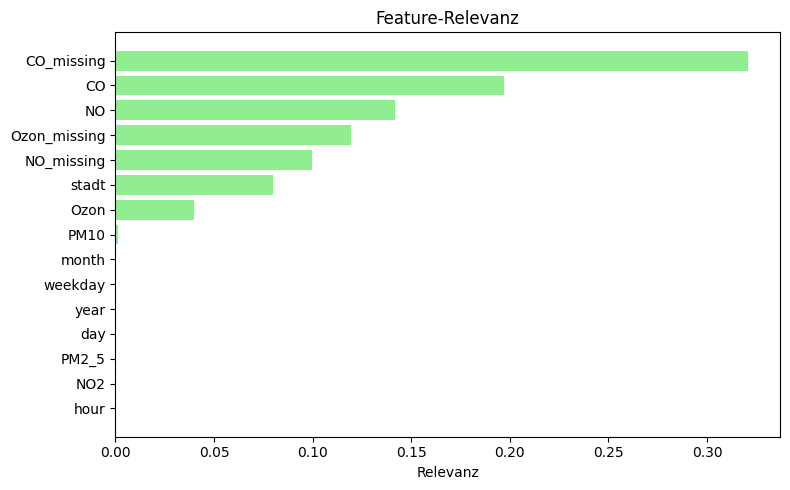

In [282]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Feature-Relevanz")
plt.xlabel("Relevanz")
plt.tight_layout()
plt.show()

#das Ganze können wir auch noch visualisieren, um die Interpretation ggf zu vereinfachen

### Fenster als zeitlicher Fokus
Fenster erlauben es, einfacher Trends und Muster zu erkennen, da es einfacher wird, diese zu vergleichen.

In [283]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

window_spec = Window.orderBy("date").rowsBetween(-2, 0)

df_timecluster_windows = df_clustered.withColumn("PM10_3hr_avg", avg("PM10").over(window_spec))

#so haben wir ein kurzfristige PM10-Trend-Auswertung
#avg ist nicht Pflicht, man kann dasselbe auch mit anderen Metriken wie min, max, sum, rank, usw machen


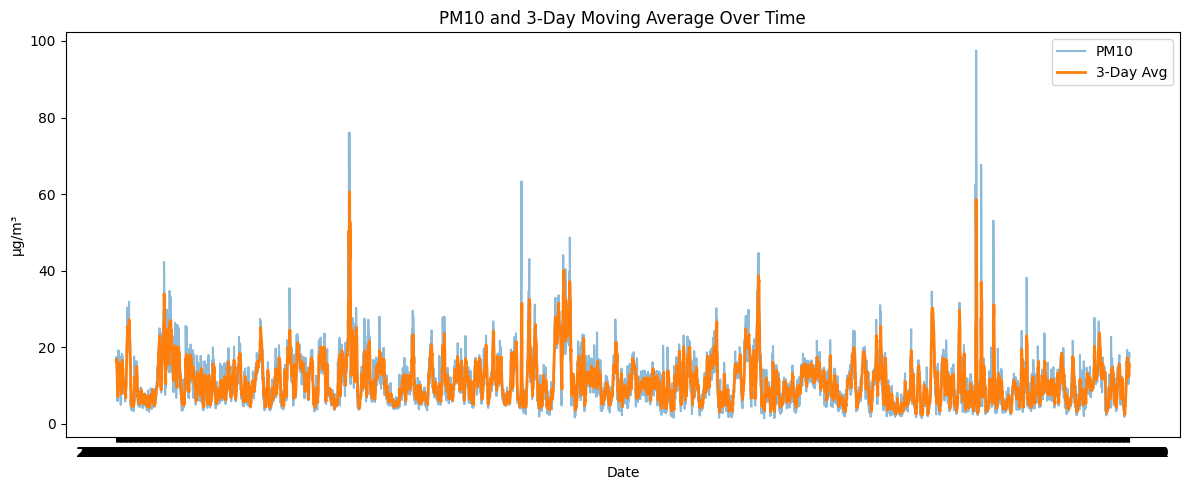

In [284]:
#Visualisierung hilft beim ERkennen von zB spontnane Ausreissern, rhytmischen zeitlichen Mustern, Outliern usw
import matplotlib.pyplot as plt

df_plot = df_timecluster_windows.select("date", "PM10", "PM10_3hr_avg").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["PM10"], label="PM10", alpha=0.5)
plt.plot(df_plot["date"], df_plot["PM10_3hr_avg"], label="3-Day Avg", linewidth=2)
plt.legend()
plt.title("PM10 and 3-Day Moving Average Over Time")
plt.xlabel("Date")
plt.ylabel("µg/m³")
plt.tight_layout()
plt.show()


In [285]:
df_save = df_timecluster_windows.toPandas()

df_save.to_csv("data/ML/ML_Data.csv")